In [1]:
#check if mace_run_train is available
#!whre mace_run_train

In [1]:
#import libraries
import numpy as np
from ase.io import read, write
from ase import Atoms
import os
os.makedirs('config', exist_ok=True) #esto crea una carpeta llamda config si es que no existe
import torch

In [3]:
db = read('251006_training_data.xyz',':')

In [1]:
#len(db)

In [5]:
#dividing the dataframe to get 2 sets, one for training and the other for testing
write('train.xyz', db[:250])
write('test.xyz', db[250:])

In [23]:
%%writefile config_mace_3bpa.yml
model: "MACE"
num_channels: 32
max_L: 0
r_max: 4.0
name: "mace_test"
train_file: "train.xyz"
valid_fraction: 0.1
test_file: "test.xyz"
energy_key: "energy"
forces_key: "forces"
E0: "average"
batch_size: 20
max_num_epochs: 10
device: cpu
seed: 123

Overwriting config_mace_3bpa.yml


In [24]:
import warnings
warnings.filterwarnings("ignore")
from mace.cli.run_train import main as mace_run_train_main
import sys
import logging

def train_mace(config_file_path):
    logging.getLogger().handlers.clear()
    sys.argv = ["program", "--config", config_file_path]  # Simulates command line
    mace_run_train_main()  # Calls the main function directly

train_mace("config_mace_3bpa.yml")

2025-10-14 01:11:10.370 INFO: ===========VERIFYING SETTINGS===========
2025-10-14 01:11:10.371 INFO: MACE version: 0.3.14
2025-10-14 01:11:10.372 INFO: Using CPU
2025-10-14 01:11:10.414 INFO: ===========LOADING INPUT DATA===========
2025-10-14 01:11:10.415 INFO: Using heads: ['Default']
2025-10-14 01:11:10.416 INFO: Using the key specifications to parse data:
2025-10-14 01:11:10.416 INFO: Default: KeySpecification(info_keys={'energy': 'energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head', 'elec_temp': 'elec_temp', 'total_charge': 'total_charge', 'polarizability': 'polarizability', 'total_spin': 'total_spin'}, arrays_keys={'forces': 'forces', 'charges': 'REF_charges'})
2025-10-14 01:11:10.416 INFO: =============    Processing head Default     ===========
2025-10-14 01:11:10.467 WARNING: Since ASE version 3.23.0b1, using energy_key 'energy' is no longer safe when communicating between MACE and ASE. We recommend using a different key, rewriting 'en

In [8]:
from ase import units #physical constants
from ase.md.langevin import Langevin #langevin dinamics integrator
from ase.io import read, write # read/write chemical structure files
import numpy as np 
import time #timing performance

from mace.calculators import MACECalculator # import the machine learning potential -> gives acces to mace as a "calculator" that can predict energies and forces

calculator = MACECalculator(model_paths='mace_test.model', device='cpu') #loads the trained MACe model
init_conf = read('test.xyz', '0') # loads the starting structure for MD, loads a singe molecular configuration to start the simulation
init_conf.set_calculator(calculator) # connect the ML calculator to the atoms (en teoria se puede usar init_conf.cal = calculator pero no lo he probado)

dyn = Langevin(init_conf, 0.5*units.fs, temperature_K=310, friction=5e-3) #uses langevin dynamics (constant temperature)
#defines a function to save simulation snapshots
def write_frame():
        dyn.atoms.write('md_3bpa.xyz', append=True)
dyn.attach(write_frame, interval=50) #indicates the simulator when to save frames
dyn.run(100) #execute the molecular dynamics, each step calculates forces using mace, updates atom positions and velocities, applies thermostat and saves trajectory frame every 50 steps
print("MD finished!")

2025-10-14 00:52:04.599 INFO: Using CPU
Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.
MD finished!


In [ ]:
from ase.io import read

trajectory = read('md_3bpa.xyz', index=':')
print(f"trajectory contains {len(trajectory)} frames")
print(f"each frame has {len(trajectory[0])} atoms")

# Print energies from the trajectory
print("\nEnergies from MD simulation:")
for i, atoms in enumerate(trajectory):
    if hasattr(atoms, 'get_potential_energy'):
        energy = atoms.get_potential_energy()
        print(f"Frame {i}: Energy = {energy:.4f} eV")

Trajectory contains 9 frames
Each frame has 10 atoms

Energies from MD simulation:
Frame 0: Energy = -70.2193 eV
Frame 1: Energy = -71.7766 eV
Frame 2: Energy = -72.1329 eV
Frame 3: Energy = -70.2193 eV
Frame 4: Energy = -71.7766 eV
Frame 5: Energy = -72.1329 eV
Frame 6: Energy = -73.0844 eV
Frame 7: Energy = -74.6088 eV
Frame 8: Energy = -75.0692 eV


In [12]:
# Check that MPS is available
if torch.backends.mps.is_available():
    print('available')
else:
    print("not available")

available


In [13]:
mps_device = torch.device("mps")

# Create a Tensor directly on the mps device
x = torch.ones(5, device=mps_device, dtype=torch.float32)
    # Or
#x = torch.ones(5, device="mps")

    # Any operation happens on the GPU
y = x * 2
y

tensor([2., 2., 2., 2., 2.], device='mps:0', dtype=torch.float32)

In [25]:
%%writefile config_mace_3bpa_mps.yml
model: "MACE"
num_channels: 32
max_L: 0
r_max: 4.0
name: "mace_test"
train_file: "train.xyz"
valid_fraction: 0.1
test_file: "test.xyz"
energy_key: "energy"
forces_key: "forces"
E0: "average"
batch_size: 10
max_num_epochs: 5
device: mps
seed: 123
default_dtype: "float32"

Overwriting config_mace_3bpa_mps.yml


In [26]:
import warnings
warnings.filterwarnings("ignore")
from mace.cli.run_train import main as mace_run_train_main
import sys
import logging

def train_mace(config_file_path):
    logging.getLogger().handlers.clear()
    sys.argv = ["program", "--config", config_file_path]  # Simulates command line
    mace_run_train_main()  # Calls the main function directly

train_mace("config_mace_3bpa_mps.yml")

2025-10-14 01:12:40.217 INFO: ===========VERIFYING SETTINGS===========
2025-10-14 01:12:40.218 INFO: MACE version: 0.3.14
2025-10-14 01:12:40.219 INFO: Using MPS GPU acceleration
2025-10-14 01:12:40.261 INFO: ===========LOADING INPUT DATA===========
2025-10-14 01:12:40.262 INFO: Using heads: ['Default']
2025-10-14 01:12:40.263 INFO: Using the key specifications to parse data:
2025-10-14 01:12:40.263 INFO: Default: KeySpecification(info_keys={'energy': 'energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head', 'elec_temp': 'elec_temp', 'total_charge': 'total_charge', 'polarizability': 'polarizability', 'total_spin': 'total_spin'}, arrays_keys={'forces': 'forces', 'charges': 'REF_charges'})
2025-10-14 01:12:40.264 INFO: =============    Processing head Default     ===========
2025-10-14 01:12:40.315 WARNING: Since ASE version 3.23.0b1, using energy_key 'energy' is no longer safe when communicating between MACE and ASE. We recommend using a different k

TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [2]:
#esto es una prueba para poder ver los cosos del validation loss y training loss
import json
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#with this I can read the information that is the file
results = 'results/mace_test_run-123_train.txt'

data = []
with open(results, 'r') as f:
    for line in f:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError:
            continue

In [4]:
df = pd.DataFrame(data)
df

,loss,mae_e,mae_e_per_atom,rmse_e,rmse_e_per_atom,q95_e,mae_f,rel_mae_f,rmse_f,rel_rmse_f,q95_f,time,mode,epoch,head
0,1.454524e+01,15.310976,1.387950,20.261749,1.945139,31.221778,0.54929,100.768045,1.163349,99.928959,1.784653,0.523481,eval,NaN,Default
1,8.710613e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.387137,opt,0.0,NaN
2,6.421458e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.464410,opt,0.0,NaN
3,3.718657e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.348136,opt,0.0,NaN
4,9.685795e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.292968,opt,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,6.169618e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.320278,opt,9.0,NaN
664,6.489460e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.390515,opt,9.0,NaN
665,3.771066e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.350354,opt,9.0,NaN
666,3.437495e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.366092,opt,9.0,NaN


In [5]:
#here we can separeate the training that is tagged as opt and the validation that is tagged as eval
train_df = df[df['mode']=='opt'].copy()
val_df = df[df['mode']=='eval'].copy()

train_df['epoch'] = train_df['epoch'].fillna(method='ffill')
val_df['epoch'] = val_df['epoch'].fillna(method='ffill')

/var/folders/ss/rl4f6d014xn7w9_n37314vvm0000gp/T/ipykernel_885/2433068329.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df['epoch'] = train_df['epoch'].fillna(method='ffill')
/var/folders/ss/rl4f6d014xn7w9_n37314vvm0000gp/T/ipykernel_885/2433068329.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  val_df['epoch'] = val_df['epoch'].fillna(method='ffill')


In [16]:
val_df

,loss,mae_e,mae_e_per_atom,rmse_e,rmse_e_per_atom,q95_e,mae_f,rel_mae_f,rmse_f,rel_rmse_f,q95_f,time,mode,epoch,head
0,14.545235,15.310976,1.387950,20.261749,1.945139,31.221778,0.549290,100.768045,1.163349,99.928959,1.784653,0.523481,eval,NaN,Default
12,13.824550,15.687664,1.420514,20.519747,1.989098,30.132125,0.548223,100.572338,1.127824,96.877479,1.711156,0.200498,eval,0.0,Default
24,14.009691,16.309121,1.477036,20.933574,2.053840,27.835200,0.567148,104.044110,1.093102,93.894891,1.765322,0.194061,eval,1.0,Default
36,12.245875,16.058615,1.447578,20.597750,2.015359,28.115427,0.494744,90.761485,1.037665,89.133025,1.618521,0.193846,eval,2.0,Default
48,10.557341,19.195096,1.612429,23.096867,2.082920,30.184046,0.465493,85.395340,0.950690,81.662084,1.350644,0.179515,eval,3.0,Default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,16.014796,18.481431,1.581143,22.268815,2.064699,30.133862,0.494080,90.639678,0.984642,84.578482,1.738895,0.244722,eval,5.0,Default
631,13.252312,17.513387,1.540559,21.728208,2.068278,30.460518,0.470870,86.381800,0.914173,78.525351,1.786364,0.218021,eval,6.0,Default
643,9.020668,18.571642,1.607417,22.641430,2.146613,30.700821,0.439943,80.708232,0.860633,73.926319,1.456309,0.244753,eval,7.0,Default
655,8.736809,20.777911,1.712517,24.854421,2.152423,34.790812,0.432961,79.427284,0.873132,74.999970,1.257190,0.210036,eval,8.0,Default


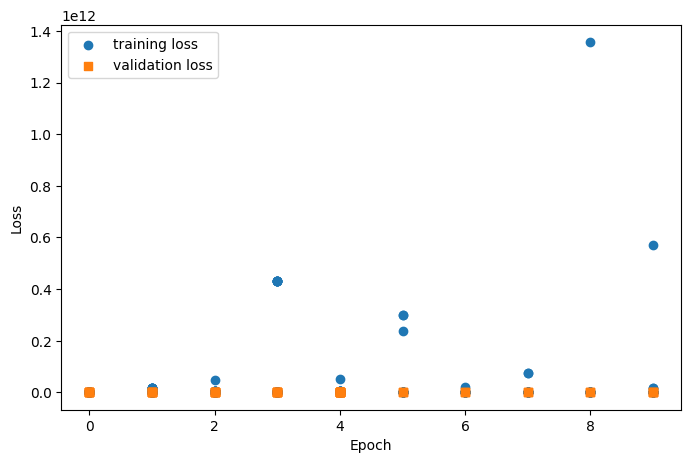

In [15]:
#aca voy a graficar lo del training loss y eso, me falta poder ver de forma mas bonita esta cosa pero la Shannon del futuro se va encargar, porque ya me canse por hoy lol
plt.figure(figsize=(8,5))
plt.scatter(train_df['epoch'],train_df['loss'], label='training loss', marker='o')
plt.scatter(val_df['epoch'],val_df['loss'], label='validation loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()